In [22]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
import numpy as np
from matplotlib import pyplot as plt


In [23]:
df_train = pd.read_csv("train_data.csv")
df_train = df_train.drop(columns="SubwayStation")

df_test = pd.read_csv("test_data.csv")
df_test = df_test.drop(columns=["SubwayStation"])
df_train["SalePrice"].values[0]

141592

Spytac sie prowadzacych czy OHE jest lepsze, czy mapping; jakby ujowo działało, to dorzucic stacje metra jeszcze

In [24]:
def encode_data(df:pd.DataFrame):
    busTimeMapping = {'5min~10min': 2, '0~5min': 1, '10min~15min': 3}
    subwayTimeMapping = {'5min~10min': 2, '0-5min': 1, '10min~15min': 3, '15min~20min':4, 'no_bus_stop_nearby':5}

    df['TimeToBusStop'] = df['TimeToBusStop'].replace(busTimeMapping)
    df['TimeToSubway'] = df['TimeToSubway'].replace(subwayTimeMapping)

    # nie wiem czy jest roznica miedzy mappingiem czy OHE

    df = pd.get_dummies(df, columns=["HallwayType", "HeatingType", "AptManageType"])

    return df



def encode_labels(df:pd.DataFrame):
    i=0
    for value in df.SalePrice.values:
        if value < 100000:
            df.SalePrice.values[i] = 0
        elif value < 350000:
            df.SalePrice.values[i] = 1
        else:
            df.SalePrice.values[i] = 2
        i += 1
    return df

In [25]:
df_train = encode_data(df_train)
df_train = encode_labels(df_train)
df_test = encode_data(df_test)



In [26]:
df_train.SalePrice.value_counts()

SalePrice
1    2998
2     570
0     556
Name: count, dtype: int64

In [27]:
df_train = pd.get_dummies(df_train, columns=["SalePrice"])

In [28]:
train = df_train.sample(frac=0.8, random_state=997)
val = df_train.drop(train.index)

In [29]:
X_train = train.values[:, :-3].astype('float32')
X_val = val.values[:, :-3].astype('float32')
X_test = df_test.values.astype('float32')

Y_train = train.values[:, -3:].astype('float32')
Y_val = val.values[:, -3:].astype('float32')

In [30]:
# normalizacja scalerem filtrowanym do danych treningowych
scaler = StandardScaler()
scaler.fit(np.vstack((X_train, X_val)))
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)


In [31]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [32]:
train_ds = data.TensorDataset(torch.from_numpy(X_train_norm).to(device),torch.from_numpy(Y_train).to(device))
val_ds = data.TensorDataset(torch.from_numpy(X_val_norm).to(device),torch.from_numpy(Y_val).to(device))
test_ds = data.TensorDataset(torch.from_numpy(X_test_norm).to(device),torch.zeros(X_test_norm.shape[0], 1).to(device))

train_loader = data.DataLoader(train_ds, shuffle=True, batch_size=1000)
val_loader = data.DataLoader(val_ds, batch_size=X_val_norm.shape[0])
test_loader = data.DataLoader(test_ds, batch_size=1000)

In [33]:
class Aproximator(nn.Module):

    def __init__(self, num_inputs, num_labels, hidden_size = [30, 30, 30], BN=False, dropout=0):
        super(Aproximator,self).__init__()

        layers = []
        layer_sizes = [num_inputs] + hidden_size
        for layer in range (1, len(layer_sizes)):
            if BN:
                layers += [nn.Linear(layer_sizes[layer-1], layer_sizes[layer]),
                           nn.BatchNorm1d(layer_sizes[layer]),
                           nn.Dropout(dropout),
                           torch.nn.Tanh()
                           ]
            else:
                layers += [nn.Linear(layer_sizes[layer-1], layer_sizes[layer]),
                           nn.Dropout(dropout),
                           torch.nn.Tanh()
                           ]
        layers += [nn.Linear(layer_sizes[-1], num_labels)]

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


In [34]:
####### Parametry
weight_decay = 1e-2
lr = 1e-3

input_size = X_train_norm.shape[1]
out_size = 3
hidden_sizes = [100, 80, 50, 30]
dropout = 0.2
BN=True

weights_loss = torch.tensor([6.86, 1.33, 7.27])

#######
Aprox1 = Aproximator(input_size, out_size, hidden_sizes, BN=BN, dropout=dropout).to(device)


optim = torch.optim.Adam(Aprox1.parameters(), weight_decay=weight_decay, lr=lr)
loss_fnc = torch.nn.CrossEntropyLoss(weight=weights_loss).to(device)


In [35]:
def measure_accuracy(model, data_loader):
    positive=0
    total = 0

    with torch.no_grad():
        model.eval()
        for input, labels in data_loader:
            output = torch.softmax(model(input), dim=1)

            positive += sum(torch.argmax(output, dim=1) == torch.argmax(labels, dim=1))

            total+=input.shape[0]


    return  positive/total

In [36]:
def train(data_loader, epoch):

    Aprox1.train(mode=True)
    acc=[]
    loss_=[]
    epochs=[]

    for n in range(epoch):

        epoch_losses = []
        for input, label in data_loader:

            pred = Aprox1.forward(input)
            loss = loss_fnc(pred, label)

            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_losses.append(loss.item())


        if n%10==0:
            loss_mean = np.array(epoch_losses).mean()
            val_acc = measure_accuracy(Aprox1, val_loader)

            acc.append(val_acc.cpu())
            loss_.append(loss_mean)
            epochs.append(n)

            print(f"Epoch {n} loss {loss_mean:.3} val_acc {val_acc:.3}")

    Aprox1.eval()

    plt.plot(epochs,loss_, label="loss value")
    plt.title("Loss")
    plt.legend()
    plt.show()

    plt.plot(epochs, acc, label="accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.show()



Epoch 0 loss 2.95 val_acc 0.267
Epoch 10 loss 1.4 val_acc 0.702
Epoch 20 loss 1.01 val_acc 0.782
Epoch 30 loss 0.852 val_acc 0.801
Epoch 40 loss 0.866 val_acc 0.794
Epoch 50 loss 0.879 val_acc 0.807
Epoch 60 loss 0.844 val_acc 0.789
Epoch 70 loss 0.848 val_acc 0.789
Epoch 80 loss 0.859 val_acc 0.793
Epoch 90 loss 0.859 val_acc 0.802
Epoch 100 loss 0.846 val_acc 0.799
Epoch 110 loss 0.845 val_acc 0.785
Epoch 120 loss 0.86 val_acc 0.789
Epoch 130 loss 0.847 val_acc 0.79
Epoch 140 loss 0.82 val_acc 0.815
Epoch 150 loss 0.851 val_acc 0.795
Epoch 160 loss 0.834 val_acc 0.804
Epoch 170 loss 0.833 val_acc 0.783
Epoch 180 loss 0.855 val_acc 0.778
Epoch 190 loss 0.825 val_acc 0.775
Epoch 200 loss 0.849 val_acc 0.806
Epoch 210 loss 0.848 val_acc 0.795
Epoch 220 loss 0.853 val_acc 0.793
Epoch 230 loss 0.851 val_acc 0.799
Epoch 240 loss 0.831 val_acc 0.798
Epoch 250 loss 0.833 val_acc 0.807
Epoch 260 loss 0.848 val_acc 0.801
Epoch 270 loss 0.824 val_acc 0.798
Epoch 280 loss 0.807 val_acc 0.795
Epo

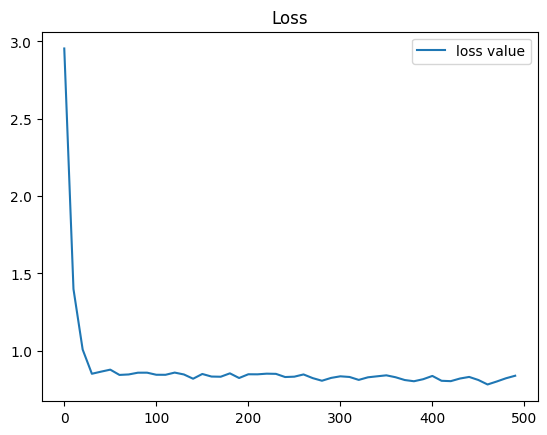

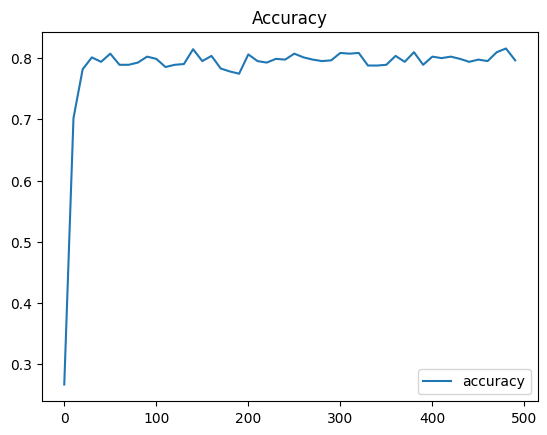

In [37]:
train(train_loader, 500)


In [38]:
model_path = 'With_BN__dropout__L2reg__500epoch__80acc__lossWeights717.pth'
torch.save(Aprox1.state_dict(), model_path)

In [39]:
# evalke na testowym jeszcze + zapis do pliku + rzutowanie na [0, 1, 2]